In [81]:

%load_ext autoreload
%autoreload 2
import bnl
from bnl import fio, mtr, viz

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [82]:
fio.ROOT_DATA_DIR = '/Users/tomxi/data/'
tid = '1437'

est = fio.adobe_hiers(tid)
ref1, ref2 = fio.salami_ref_hiers(tid)

In [84]:
import mir_eval
from mir_eval import hierarchy as meh

In [100]:
meh.evaluate(ref1.itvls, ref1.labels, ref2.itvls, ref2.labels, frame_size=0.5)

OrderedDict([('T-Precision reduced', 0.5557347883218311),
             ('T-Recall reduced', 0.7672728696070399),
             ('T-Measure reduced', 0.6445922262364967),
             ('T-Precision full', 0.7053791844530091),
             ('T-Recall full', 0.7551180157496541),
             ('T-Measure full', 0.7294016449211325),
             ('L-Precision', 0.7380989976715843),
             ('L-Recall', 0.7024500887886143),
             ('L-Measure', 0.7198334459025278)])

In [88]:
est.T

223.477

In [102]:
a,b = mtr.align_hier(ref2, ref1)
mtr.lmeasure(a, b)

(0.698714783851908, 0.7385688604949213, 0.7180892703401999)

In [103]:
mtr.lmeasure(ref2, ref1)

(0.698714783851908, 0.7385688604949213, 0.7180892703401999)

In [110]:
new_ref1, new_est = mtr.align_hier(ref1, est)

(<Figure size 500x530 with 12 Axes>,
 array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: xlabel='Time (s)'>], dtype=object))

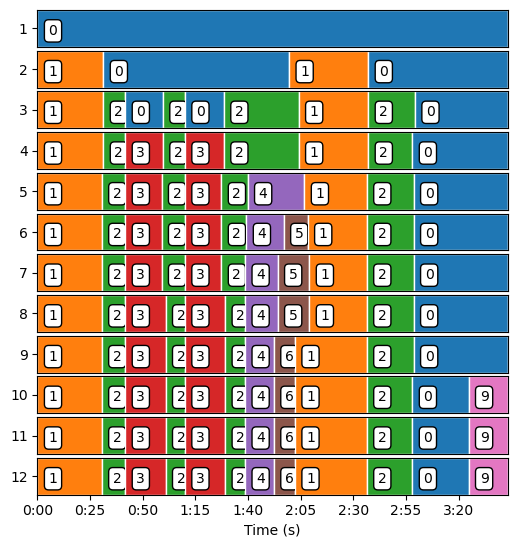

In [113]:
new_est.plot()

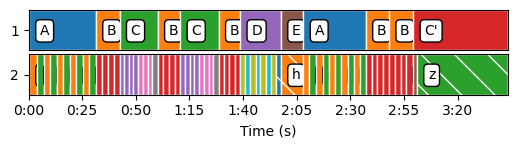

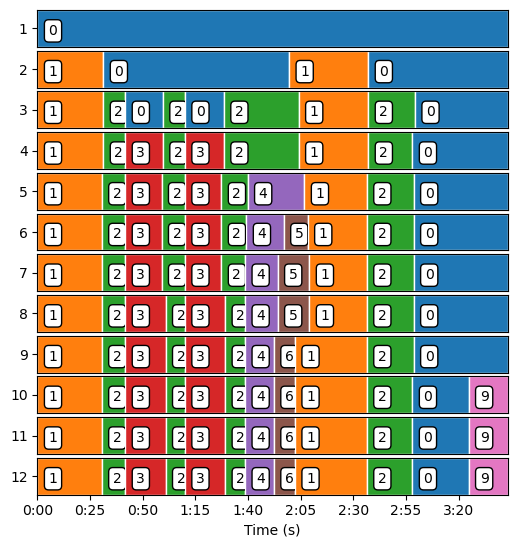

In [144]:
ref1.plot();
plt.show()

est.plot();
plt.show()


In [131]:

meh.lmeasure(new_ref1.itvls, new_ref1.labels, new_est.itvls, new_est.labels, frame_size=0.5)

(0.5051709155278655, 0.9358046951904566, 0.6561406190476436)

In [142]:
meh.evaluate(ref1.itvls, ref1.labels, est.itvls, est.labels, frame_size=0.5)

OrderedDict([('T-Precision reduced', 0.25121720598736086),
             ('T-Recall reduced', 0.5702192173990223),
             ('T-Measure reduced', 0.34877654439703654),
             ('T-Precision full', 0.6329748846231609),
             ('T-Recall full', 0.6275923005059856),
             ('T-Measure full', 0.6302721008281071),
             ('L-Precision', 0.5051709155278655),
             ('L-Recall', 0.9358046951904566),
             ('L-Measure', 0.6561406190476436)])

In [151]:
print('\n'.join([
    f"{fs}:\t"+str(mtr.time_lmeasure(ref1, est, frame_size=fs))
    for fs in [0, 0.5, 1]
]))


0:	(0.6817412376403809, (0.3722670604479252, 0.608971682440065, 0.4620691952108713))
0.5:	(0.29614996910095215, (0.5051709155278655, 0.9358046951904566, 0.6561406190476436))
1:	(0.11532187461853027, (0.49991346378626766, 0.9337251534292227, 0.6511847128975669))


## Let's debug the hell out of this.

Start with plotting the meet mats

In [200]:
import numpy as np
est, ref1 = mtr.align_hier(est, ref1)


(446, 446)


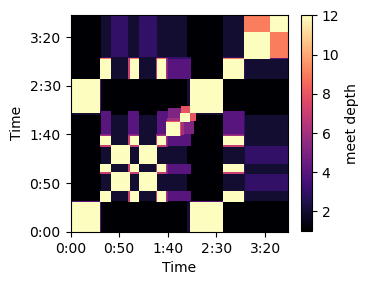

In [192]:
bs = est.ticks
ts = (bs[1:] + bs[:-1]) / 2.0
n_seg = len(ts)

my_meet = np.empty((n_seg, n_seg))
for u in range(n_seg):
    for v in range(n_seg):
        my_meet[u, v] = est.meet(ts[u], ts[v])

mappable = viz.sq(my_meet, bs)
plt.colorbar(mappable, label='meet depth', shrink=0.8)
print(my_meet.shape)

In [201]:
# mir_eval's meet. using my ticks for convenience
frame_size = 0.5
est.update_sr(1 / frame_size)
est_meh_meet = meh._meet(est.itvls, est.labels, frame_size)
ref1_meh_meet = meh._meet(ref1.itvls, ref1.labels, frame_size)


### Alright so the above seems like meet mats are the same. Let's plot significant pairs at each t in u,v spacem

In [199]:
ref1_meh_meet.shape

(447, 447)

In [207]:
meh._gauc(est_meh_meet, ref1_meh_meet, True, None)

0.5076774768385888

In [212]:
mtr.time_lmeasure(est, ref1)

(0.5675950050354004,
 (0.6090212951186889, 0.3722804662015512, 0.46209380357866797))

In [220]:
print()
print(mtr.recall_at_t(ref1, est, 6.25))


0.8704999548180916


In [228]:
ts = est.ticks
my_r_t = [mtr.recall_at_t(ref1, est, t) for t in ts]

In [275]:
ref1_meh_meet.toarray()

array([[2, 2, 2, ..., 0, 0, 0],
       [2, 2, 2, ..., 0, 0, 0],
       [2, 2, 2, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 2, 2, 2],
       [0, 0, 0, ..., 2, 2, 2],
       [0, 0, 0, ..., 2, 2, 2]], dtype=uint8)

In [281]:
np.array(my_r_t).mean()

0.6077420639667219

In [289]:
my_rho = mtr.gauc(ref1_meh_meet, est_meh_meet)
meh_rho = meh._gauc(ref1_meh_meet, est_meh_meet, True, None)
print(my_rho, meh_rho)

(0.9356297432924098, array([0.88681251, 0.88681251, 0.88681251, 0.88681251, 0.88681251,
       0.88681251, 0.88681251, 0.88268922, 0.88268922, 0.88268922,
       0.88268922, 0.88268922, 0.88268922, 0.88268922, 0.88681251,
       0.88681251, 0.88681251, 0.88681251, 0.88681251, 0.88681251,
       0.88268922, 0.88268922, 0.88268922, 0.88268922, 0.88268922,
       0.88268922, 0.88681251, 0.88681251, 0.88681251, 0.88681251,
       0.88681251, 0.88681251, 0.88268922, 0.88268922, 0.88268922,
       0.88268922, 0.88268922, 0.88268922, 0.88681251, 0.88681251,
       0.88681251, 0.88681251, 0.88681251, 0.88681251, 0.88268922,
       0.88268922, 0.88268922, 0.88268922, 0.88268922, 0.88268922,
       0.88681251, 0.88681251, 0.88681251, 0.88681251, 0.88681251,
       0.88681251, 0.88268922, 0.88268922, 0.88268922, 0.88268922,
       0.88268922, 0.58272702, 0.9774865 , 0.9774865 , 0.9774865 ,
       0.9774865 , 0.9774865 , 0.9774865 , 0.9774865 , 0.9774865 ,
       0.9774865 , 0.9774865 , 0.9774865 

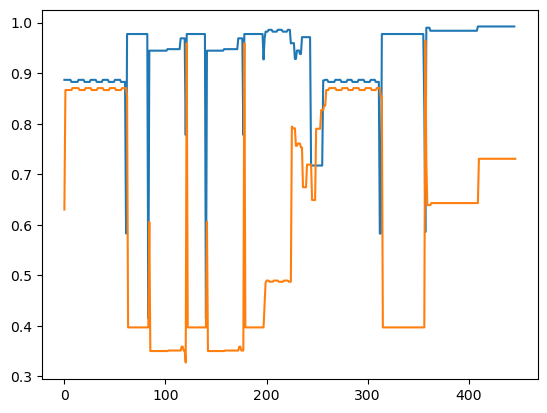

In [282]:
plt.plot(r_t)
plt.plot(my_r_t)

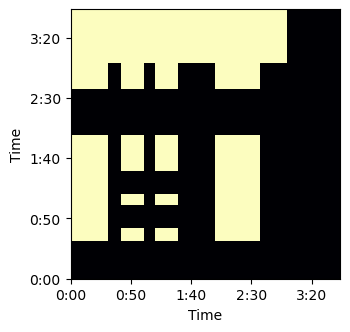

In [242]:
# My significant pairs at t=50sec
ref_measures = mtr.recall_at_t(est, ref1, 50, debug=True)
bs = ref_measures['bs']
viz.sq(ref_measures['iota'], bs)

In [267]:
grid_area =bnl.utils.bs2grid_area(bs)
iota = np.sum((ref_measures['iota'] * grid_area))
alpha = np.sum(ref_measures['alpha'] * grid_area)
total_area = np.sum(grid_area)
print(iota * 2/total_area, alpha * 2/total_area, alpha/ iota)

0.7323627723324262 0.0984677088704809 0.13445209476839096


In [263]:
iota

18287.819629999998

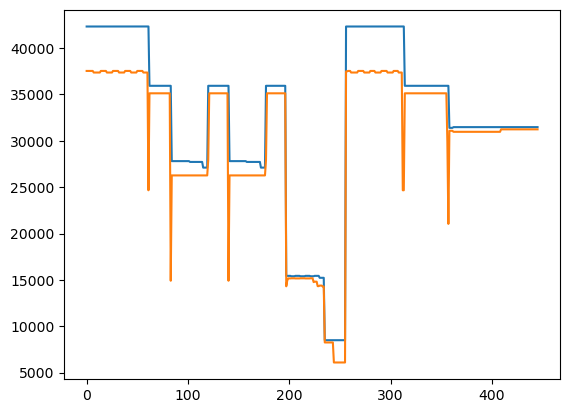

In [297]:
# MIR_EVAL significant pairs at t=50sec
m, r_t, i_t, n_t = mtr.gauc(ref1_meh_meet, est_meh_meet)
plt.plot(n_t)
plt.plot(n_t - i_t)


In [245]:
r_t[100]

0.9445563066302316

In [211]:
mtr.time_lmeasure(est, ref1, 0.5)

(0.27361202239990234,
 (0.9356297432924111, 0.5076774768385888, 0.6582079555961969))

In [290]:
# Let's do mir_eval first, cuz that's less familiar, let's get I(u,v|t) from mir_eval
out = mtr.gauc(est_meh_meet, ref1_meh_meet)


In [296]:
out[1]

array([0.87167638, 0.87167638, 0.87167638, 0.87167638, 0.87167638,
       0.87167638, 0.87167638, 0.86770545, 0.86770545, 0.86770545,
       0.86770545, 0.86770545, 0.86770545, 0.86770545, 0.87167638,
       0.87167638, 0.87167638, 0.87167638, 0.87167638, 0.87167638,
       0.86770545, 0.86770545, 0.86770545, 0.86770545, 0.86770545,
       0.86770545, 0.87167638, 0.87167638, 0.87167638, 0.87167638,
       0.87167638, 0.87167638, 0.86770545, 0.86770545, 0.86770545,
       0.86770545, 0.86770545, 0.86770545, 0.87167638, 0.87167638,
       0.87167638, 0.87167638, 0.87167638, 0.87167638, 0.86770545,
       0.86770545, 0.86770545, 0.86770545, 0.86770545, 0.86770545,
       0.87167638, 0.87167638, 0.87167638, 0.87167638, 0.87167638,
       0.87167638, 0.86770545, 0.86770545, 0.86770545, 0.86770545,
       0.86770545, 0.37141093, 0.48452954, 0.48452954, 0.48452954,
       0.48452954, 0.48452954, 0.48452954, 0.48452954, 0.48452954,
       0.48452954, 0.48452954, 0.48452954, 0.48452954, 0.48452

## Let's plot!

- Figure 1: how framesize affect the triplet metrics
- Figure 2: how continuous compares with 0.5: scatter plot


799-0
799-1


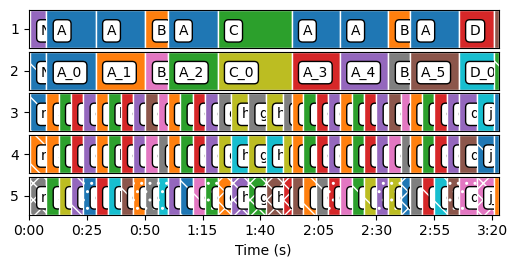

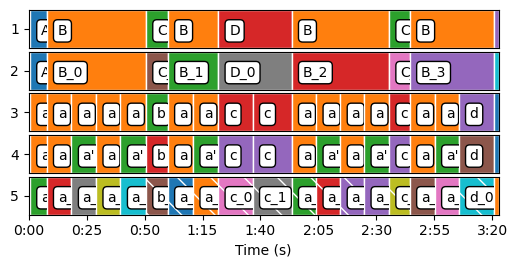

In [50]:
import random
tids = bnl.fio.salami_tids()
tid = random.choice(tids)
salami_hiers = bnl.fio.salami_ref_hiers(tid=tid)
while len(salami_hiers) < 2:
    tid = random.choice(tids)
    salami_hiers = bnl.fio.salami_ref_hiers(tid=tid)

hiers = {'-'.join([str(tid), str(i)]): h for i, h in enumerate(salami_hiers)}

for tid, h in hiers.items():
    print(tid)
    h.expand(format='slm', always_include=False).plot();

## Comparing Mir_eval implementation and my implementation


### Ok. now I need to do this over all tracks that have 2 annotations and record all the times and results, for several configs


In [2]:
%load_ext autoreload
%autoreload 2
import bnl
from bnl import metrics
import os
from pqdm.processes import pqdm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
# Create output directory if it doesn't exist
os.makedirs("./compare_implementation", exist_ok=True)

# Determine number of CPU cores to use
n_jobs = max(1, os.cpu_count() - 1)  # Leave one CPU free

# Process tracks in parallel
tids = bnl.fio.salami_tids()
pqdm(tids, metrics.time_salami_track, n_jobs=n_jobs);

QUEUEING TASKS | :   0%|          | 0/1359 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1359 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1359 [00:00<?, ?it/s]

In [19]:
## Time to collect
from glob import glob
from tqdm import tqdm
import os
import xarray as xr


In [23]:
results_fpaths = glob('./compare_implementation/*.nc')

das = []
for fp in tqdm(results_fpaths):
    tid = os.path.basename(fp).split('.')[0]
    # Load the data array and assign the tid as a coordinate
    da = xr.open_dataarray(fp)
    da = da.assign_coords(tid=tid)
    da = da.expand_dims('tid')
    das.append(da)

# Concatenate all the data arrays along the 'tid' dimension
final_da = xr.concat(das, dim='tid')


100%|██████████| 882/882 [00:07<00:00, 123.56it/s]


In [ ]:
#  Save the final data array to a NetCDF file
final_da.to_netcdf('./compare_implementation.nc')


### Alright, I can load from saved data now. Now let's do scatter plot to see how they differ

In [53]:
ls ../../../text/jo

hier_metric/ thesis/


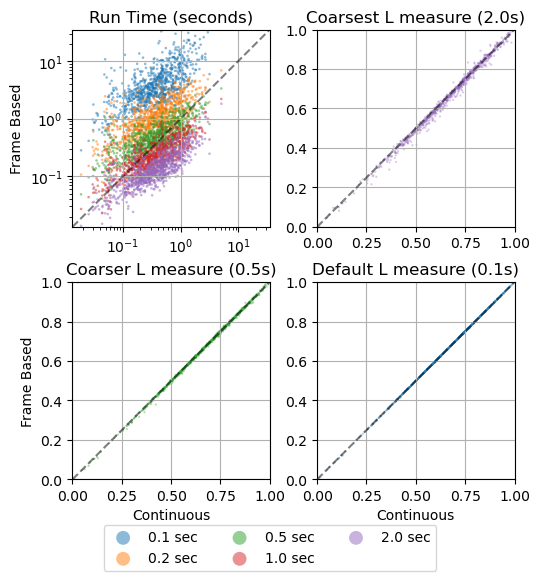

In [54]:
import numpy as np
import matplotlib.pyplot as plt
from bnl import viz
import bnl
import xarray as xr

# Load the data array from the NetCDF file
results = xr.open_dataarray('./compare_implementation.nc')
fig, axes = plt.subplots(2, 2, figsize=(5.2,5.2), constrained_layout=True)
if not isinstance(axes, np.ndarray):
    axes = np.array([axes])
else:
    axes = axes.ravel()

viz.plot_scatter_frame_vs_continuous(results, sel_dict=dict(output='run_time'), ax=axes[0])
axes[0].set_title('Run Time (seconds)')

viz.plot_scatter_frame_vs_continuous(
    results, 
    sel_dict=dict(output='lm'), 
    ax=axes[1], 
    frame_sizes=[2.0], 
    color=plt.rcParams['axes.prop_cycle'].by_key()['color'][4]
)
axes[1].set_title('Coarsest L measure (2.0s)')

viz.plot_scatter_frame_vs_continuous(results, sel_dict=dict(output='lm'), frame_sizes=[0.5], ax=axes[2], color=plt.rcParams['axes.prop_cycle'].by_key()['color'][2])
axes[2].set_title('Coarser L measure (0.5s)')

viz.plot_scatter_frame_vs_continuous(results, sel_dict=dict(output='lm'), frame_sizes=[0.1], ax=axes[3])
axes[3].set_title('Default L measure (0.1s)')

# Set the title for each subplot
# Create the legend for the middle subplot into a row of handle, and plot the thin bar under the how figure
axes[0].set_ylabel('Frame Based')
axes[2].set_ylabel('Frame Based')
axes[2].set_xlabel('Continuous')
axes[3].set_xlabel('Continuous')
handles, labels = axes[0].get_legend_handles_labels()
for h in handles:
    h.set_sizes([100])  # Adjust the size as needed
    h.set_alpha(0.5)  # Set transparency for better visibility
fig.legend(handles, labels, loc='lower center', ncol=3, fontsize=10, bbox_to_anchor=(0.5,-0.1))

for ax in axes:
    h, _ = ax.get_legend_handles_labels()
    for h in handles:
        # Set the handles back!
        h.set_sizes([3.5])  # Adjust the size as needed
        h.set_alpha(0.5)  # Set transparency for better visibility
    
# Show the plot
fig.set_constrained_layout_pads(w_pad=0, h_pad=0, wspace=0, hspace=0)
plt.savefig('../../../text/hier_metric/figs/compare_implementation.pdf', transparent=True, bbox_inches='tight')

## Hierarchy Expansion!

(<Figure size 500x250 with 5 Axes>,
 array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: xlabel='Time (s)'>],
       dtype=object))

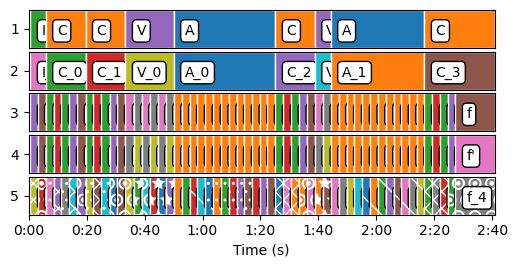

In [88]:
h = bnl.levels2H(h.levels)
h.expand().plot()

## Let's investigate!

- Transitivity, and effects of depth.
- Window and its effects. (It's faster now so we probably don't need it. Let's check the original claim that over all frames are redundant)
    - We can visualize this by looking at how window size affect the per time measures iota alpha and rho.
- Monotonicity Meet and its effect.
    - Again look at per time measures and how they change before and after.



In [4]:
tids = bnl.fio.salami_tids()
hiers = bnl.fio.salami_ref_hiers(tid=tids[0])
hiers

[<bnl.core.H at 0x12a6e7c40>, <bnl.core.H at 0x12a58b520>]

(<Figure size 500x130 with 2 Axes>,
 array([<Axes: >, <Axes: xlabel='Time (s)'>], dtype=object))

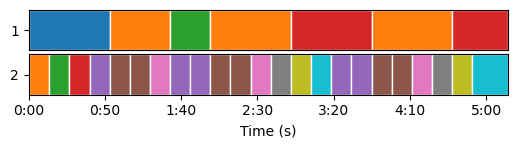

In [8]:
hiers[0].plot(text=False)